In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec

import os
import re

import scipy as sc

################################################
# Load in Factorial Experiment Data
################################################

base_path = "./factorial_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-(?P<cov>\w+)-(?P<eps>[a-zA-Z0-9]+)_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_target(?P<target>\d+[.]\d+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file)
    file_data = re.match(file_expr, file).groupdict()
    file_df["cov"] = file_data["cov"]
    file_df["eps"] = file_data["eps"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["target"] = float(file_data["target"])
    file_df["seed"] = int(file_data["seed"])
    file_df["experiment_num"] = int(file_data["seed"][-3:])
    file_dfs.append(file_df)

factorial_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs

################################################
# Load in Sample Size Data
################################################

base_path = "./sample_size_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-(?P<cov>\w+)-(?P<eps>[a-zA-Z0-9]+)_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_target(?P<target>\d+[.]\d+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file)
    file_data = re.match(file_expr, file).groupdict()
    file_df["cov"] = file_data["cov"]
    file_df["eps"] = file_data["eps"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["target"] = float(file_data["target"])
    file_df["seed"] = int(file_data["seed"])
    file_df["experiment_num"] = int(file_data["seed"][-3:])
    file_dfs.append(file_df)

sample_size_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs

################################################
# Create the names of the methods
################################################

rename_dict = {
    "OLS__L1" : "OLS-L1",
    "OLS__L2" : "OLS-L2",
    "OLS__Huber": "OLS-Huber",
    "Huber__L1": "Huber-L1",
    "Huber__L2": "Huber-L2",
    "Huber__Huber" : "Huber-Huber",
    "t-test" : "F-test"
}

factorial_df = factorial_df.rename(columns = rename_dict)
sample_size_df = sample_size_df.rename(columns = rename_dict)

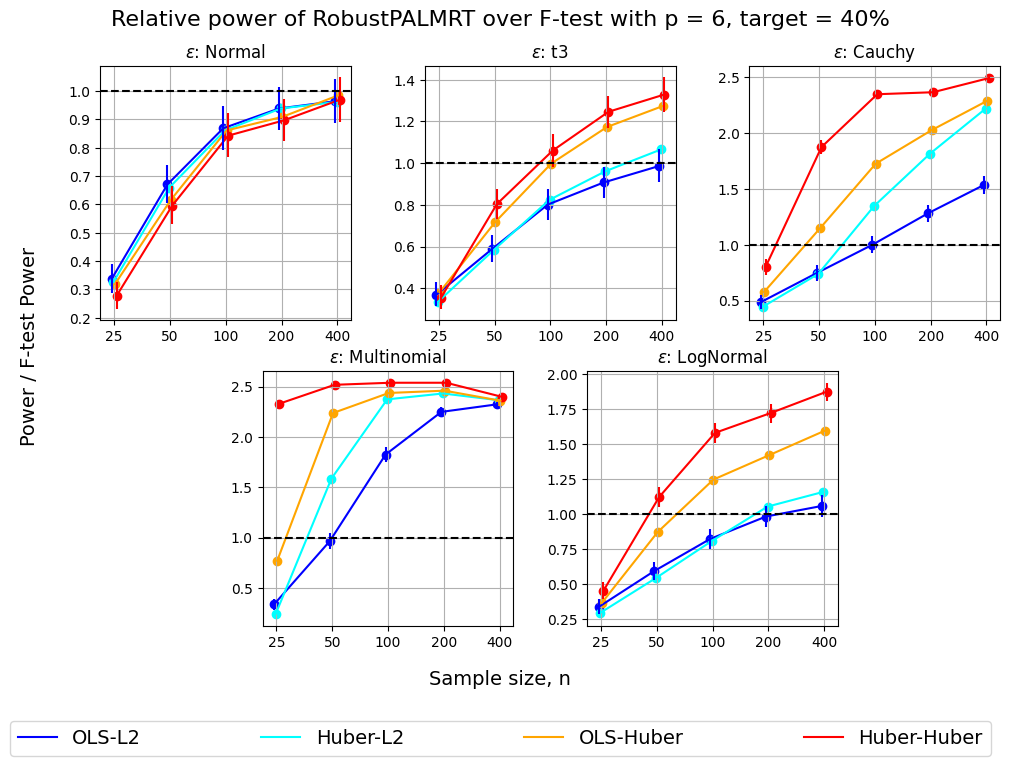

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [2]:
################################################
# Create the colors and names of the methods
################################################

plot_methods = [
    "OLS-L2",
    "Huber-L2",
    "OLS-Huber",
    "Huber-Huber"
]

colors_dict = {
    "OLS-L1" : "palegreen",
    "Huber-L1" : "green",
    "OLS-L2" : "blue",
    "Huber-L2" : "cyan",
    "OLS-Huber" : "orange",
    "Huber-Huber" : "red",
    "F-test" : "black"
}

trials = 1000
covs = ["Cauchy"]
epss = ["Normal", "t3", "Cauchy", "Multinomial", "LogNormal"]
p = 6
targets = [0, 20, 40, 60, 80, 95]

# For sample size simulations
designs = [
    ("Cauchy", "Normal"),
    ("Cauchy", "t3"),
    ("Cauchy", "Cauchy"),
    ("Cauchy", "Multinomial"),
    ("Cauchy", "LogNormal")
]

plotting_designs = [
    ("Cauchy", "Normal"),
    ("Cauchy", "t3"),
    ("Cauchy", "Cauchy"),
    ("Cauchy", "Multinomial"),
    ("Cauchy", "LogNormal")
]


################################################
# Create the full figure parameters
################################################



fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 12, figure = fig,
              height_ratios = [1, 1],
              width_ratios = [1] * 12,
              wspace = 10,
              hspace = 0.2
)
plt.subplots_adjust(left = 0.10, right = 1.0, top = 0.9, bottom = 0.1)

ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax3 = fig.add_subplot(gs[0, 8:12])
ax4 = fig.add_subplot(gs[1, 2:6])
ax5 = fig.add_subplot(gs[1, 6:10])
axs = [ax1, ax2, ax3, ax4, ax5]



def plot_errorbars_for_method_power_sample_size(ax, method_power, F_test_power, n_values, color, offset):
    # First compute exact binomial intervals
    counts_for_method = method_power * trials
    lower_bounds = sc.stats.beta.ppf(0.025,
        counts_for_method,
        trials - counts_for_method + 1)
    lower_bounds[np.isnan(lower_bounds)] = 0.

    upper_bounds = sc.stats.beta.ppf(0.975,
        counts_for_method + 1,
        trials - counts_for_method)
    upper_bounds[np.isnan(upper_bounds)] = 1.

    # Adjust the bounds to the relative plot
    lower_bounds = lower_bounds / F_test_power
    upper_bounds = upper_bounds / F_test_power

    # Plot the error bars using ax.errorbar method
    method_ratio = method_power / F_test_power
    ax.errorbar(
        n_values * (1 + offset),
        method_ratio,
        yerr = (method_ratio - lower_bounds, upper_bounds - method_ratio),
        xerr = None,
        color = color,
        ls = "none"
    )

def plot_sample_size_cell(ax, cov, eps, target):
    cov_mask = sample_size_df["cov"] == cov
    eps_mask = sample_size_df["eps"] == eps
    target_mask = sample_size_df["target"] == target

    df = sample_size_df[cov_mask & eps_mask & target_mask][["n", "F-test"] + plot_methods]

    cov_mask = factorial_df["cov"] == cov
    eps_mask = factorial_df["eps"] == eps
    target_mask = factorial_df["target"] == target
    p_mask = factorial_df["p"] == 6

    sample_size_from_factorial = factorial_df[cov_mask & eps_mask & target_mask & p_mask][["F-test"] + plot_methods]
    sample_size_from_factorial["n"] = 100

    df = pd.concat([
        df, sample_size_from_factorial
    ])

    df = df.loc[df["n"].isin([25, 50, 100, 200, 400])]

    power_by_target = df.groupby("n").aggregate(lambda x: np.mean(x <= 0.05)).reset_index()

    # On x-axis, jitter n values for readability
    for index, method in enumerate(plot_methods):
        ax.plot(
            power_by_target["n"] * (1 + (index - 1.5)/50),
            power_by_target[method]/power_by_target["F-test"],
            label = method,
            color = colors_dict[method])
        ax.scatter(
            power_by_target["n"] * (1 + (index - 1.5)/50),
            power_by_target[method]/power_by_target["F-test"],
            color = colors_dict[method])

    plot_errorbars_for_method_power_sample_size(ax,
        power_by_target["OLS-L2"],
        power_by_target["F-test"],
        power_by_target["n"],
        colors_dict["OLS-L2"],
        offset = (0 - 1.5)/50
    )

    plot_errorbars_for_method_power_sample_size(ax,
        power_by_target["Huber-Huber"],
        power_by_target["F-test"],
        power_by_target["n"],
        colors_dict["Huber-Huber"],
        offset = (3 - 1.5)/50
    )

    ax.set_title(f"$\\epsilon$: {eps}")
    ax.set_xscale("log", base = 2)
    ax.set_xticks([25, 50, 100, 200, 400])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.axhline(y = 1.0, ls = "--", color = "black")
    ax.grid(True)

target = 40

fig.supxlabel("Sample size, n", fontsize = 14)
fig.supylabel("Power / F-test Power", fontsize = 14)
fig.suptitle(f"Relative power of RobustPALMRT over F-test with p = 6, target = {target}%", fontsize = 16)

for i, (cov, eps) in enumerate(plotting_designs):
    plot_sample_size_cell(axs[i], cov, eps, target)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, mode = "expand", ncols = 4, 
    loc = "lower left", bbox_to_anchor = (0., -0.1, 1., 1.), fontsize = 14)

# Show the plot
plt.show()
fig.savefig(f"./images/4-sample_size_relative_power_sim.eps", dpi = 800, bbox_inches = "tight")